#Setup

In [1]:
# from google.colab import drive
# from os.path import join
# ROOT = "/content/drive"
# drive.mount(ROOT)

In [2]:
# %cd "/content/drive/MyDrive/study/Github/palmistry/detect"

In [5]:
import os
print(f"current path: {os.getcwd()}")

current path: /home/selfapp/Work_Sun/palmistry/detect


In [4]:
import torch
DEVICE = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print(DEVICE)

cuda


#Dataset

In [5]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from pathlib import Path
from os import listdir
import logging
from os.path import splitext
from PIL import Image
import numpy as np

In [6]:
class BasicDataset(Dataset):
    def __init__(self, images_dir: str, masks_dir: str, size: int, mask_suffix: str = '', transform=None):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.size = size
        self.mask_suffix = mask_suffix
        self.transform = transform

        self.ids = [splitext(file)[0] for file in listdir(images_dir) if not file.startswith('.')]
        if not self.ids:
            raise RuntimeError(f'No input file found in {images_dir}, make sure you put your images there')
        logging.info(f'Creating dataset with {len(self.ids)} examples')

    def __len__(self):
        return len(self.ids)

    @staticmethod
    def preprocess(pil_img, size, is_mask):
        newW, newH = size, size
        pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST if is_mask else Image.BICUBIC)
        img_ndarray = np.asarray(pil_img)
        
        if is_mask:
            img_ndarray = np.apply_along_axis(lambda x: 1 if np.all(x == 255.) else 0, 2, img_ndarray)
            # img_ndarray.shape == (256, 256)
        else:
            img_ndarray = img_ndarray.transpose((2, 0, 1))
            # img_ndarray.shape == (3, 256, 256)

        return img_ndarray

    @staticmethod
    def load(filename):
        ext = splitext(filename)[1]
        if ext == '.npy':
            return Image.fromarray(np.load(filename))
        elif ext in ['.pt', '.pth']:
            return Image.fromarray(torch.load(filename).numpy())
        else:
            return Image.open(filename)

    def __getitem__(self, idx):
        name = self.ids[idx]
        mask_file = list(self.masks_dir.glob(name + self.mask_suffix + '.*'))
        img_file = list(self.images_dir.glob(name + '.*'))

        assert len(img_file) == 1, f'Either no image or multiple images found for the ID {name}: {img_file}'
        assert len(mask_file) == 1, f'Either no mask or multiple masks found for the ID {name}: {mask_file}'
        mask = self.load(mask_file[0])
        img = self.load(img_file[0])

        assert img.size == mask.size, \
            f'Image and mask {name} should be the same size, but are {img.size} and {mask.size}'

        img = self.preprocess(img, self.size, is_mask=False)
        mask = self.preprocess(mask, self.size, is_mask=True)

        if self.transform:
            transformed_imgs = self.transform(image=img.transpose((1,2,0)), mask=mask)
            img, mask = transformed_imgs['image'].transpose((2,0,1)), transformed_imgs['mask']
        img = img / 255
        return {
            'image': torch.as_tensor(img.copy()).float().contiguous(),
            'mask': torch.as_tensor(mask.copy()).long().contiguous()
        }

class PLSUDataset(BasicDataset):
    def __init__(self, images_dir, masks_dir, size, transform=None):
        super().__init__(images_dir, masks_dir, size, mask_suffix='', transform=transform)

#Data Augmentation

In [7]:
import albumentations as A
import cv2
import os
from torch.utils.data import ConcatDataset
from pathlib import Path

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [8]:
transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(rotate_limit=10, p=0.5, border_mode=cv2.BORDER_CONSTANT),
            A.ColorJitter(brightness=0.9, contrast=0.9),
            A.CLAHE(p=1)
        ])

/home/selfapp/anaconda3/envs/Palmistry/lib/python3.10/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [9]:
# TODO: Dataset path
# dir_img = Path('./PLSU/img')
# dir_mask = Path('./PLSU/Mask')

# My dataset
# dir_img = Path('../data/Palm/palm-thick3-multiline/input')
# dir_mask = Path('../data/Palm/palm-thick3-multiline/output')

# Original Dataset  
dir_img = Path('../data/PLSU/img')
dir_mask = Path('../data/PLSU/Mask')

print(f"dir_img: {dir_img} \t dir_mask: {dir_mask}")
print(f"Check dir img: {os.path.exists(dir_img)}, dir_mask: {os.path.exists(dir_mask)}")

# TODO: Create large dataset
dataset1 = PLSUDataset(dir_img, dir_mask, size=256, transform=transform)
dataset2 = PLSUDataset(dir_img, dir_mask, size=256, transform=transform)
dataset3 = PLSUDataset(dir_img, dir_mask, size=256, transform=transform)
dataset4 = PLSUDataset(dir_img, dir_mask, size=256, transform=transform)

dataset = ConcatDataset([dataset1, dataset2, dataset3, dataset4])
# dataset = ConcatDataset([dataset1])

INFO:root:Creating dataset with 1039 examples


dir_img: ../data/PLSU/img 	 dir_mask: ../data/PLSU/Mask
Check dir img: True, dir_mask: True


In [10]:
len(dataset)

1039

#Model: U-net with Context Fusion Module

In [11]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        

    def forward(self, x):
        return self.conv(x)

In [12]:
class ContextFusion(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.context_modeling = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=1),
            nn.Softmax2d()
        )
        self.context_transform1 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=1),
            nn.Sigmoid()
        )
        self.context_transform2 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=1)
        )

    def forward(self, x):
        x1 = nn.MaxPool2d(2)(x)
        x2 = self.context_modeling(x1) * x1
        return self.context_transform1(x2) * x1 + self.context_transform2(x2)

In [13]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.cfm = ContextFusion(512)
        self.up1 = Up(1024, 512 // 2)
        self.up2 = Up(512, 256 // 2)
        self.up3 = Up(256, 128 // 2)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.cfm(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

#Evaluate

In [14]:
def F1Score(y_pred, y_true):
    epsilon = 1e-7

    tp = (y_true * y_pred).sum()
    tn = ((1 - y_true) * (1 - y_pred)).sum()
    fp = ((1 - y_true) * y_pred).sum()
    fn = (y_true * (1 - y_pred)).sum()

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
        
    return 2* (precision*recall) / (precision + recall + epsilon)

def IOUScore(y_pred, y_true):
    epsilon = 1e-7

    y_pred = np.where(y_pred > 0.1, 1, 0)
    intersection = (y_pred & y_true).sum()
    union = (y_pred | y_true).sum()
    iou = (intersection + epsilon) / (union + epsilon)

    return iou

In [15]:
def evaluate(net, dataloader, device):
    net.eval()
    num_val_batches = len(dataloader)
    f1_score = 0
    iou_score = 0
    # iterate over the validation set
    with tqdm(total=num_val_batches, desc='Validation round', unit='img') as pbar:
        for batch in dataloader:
            image, mask_true = batch['image'], batch['mask']
            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32)

            with torch.no_grad():
                # predict the mask
                mask_pred = net(image).squeeze(1) # shape = (64, 256, 256)
                mask_pred = nn.Sigmoid()(mask_pred).detach().cpu().numpy()
                mask_true = mask_true.detach().cpu().numpy()

                f1 = F1Score(mask_pred, mask_true)
                iou = IOUScore(mask_pred, mask_true)
                
                f1_score += f1
                iou_score += iou

                pbar.update(image.shape[0])
                pbar.set_postfix(**{'F1 Score (batch)': f1, 'IOU Score (batch)': iou})

    net.train()

    return f1_score/num_val_batches, iou_score/num_val_batches

#Train

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.optim import Optimizer
from tqdm import tqdm
import torch.nn.functional as F
from pathlib import Path

In [17]:
val_percent = 0.1
test_percent = 0.1

# TODO: Edit batch size
# batch_size = 64

batch_size = 32
epochs = 50

In [18]:
n_val = int(len(dataset) * val_percent)
n_test = int(len(dataset) * test_percent)
n_train = len(dataset) - n_val - n_test
train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(0))

In [19]:
# MyDebug
print(f"#train_set: {len(train_set)}")
print(f"#val_set: {len(val_set)}")
print(f"#test_set: {len(test_set)}")

#train_set: 833
#val_set: 103
#test_set: 103


In [20]:
loader_args = dict(batch_size=batch_size, num_workers=4, pin_memory=True) # maximal two workers
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

In [21]:
# MyDebug
print(f"#train_loader: {len(train_loader)}")
print(f"#val_loader: {len(val_loader)}")

#train_loader: 27
#val_loader: 3


In [23]:
net = UNet(n_channels=3, n_classes=1).to(DEVICE)

# TODO: Load init checkpoint
# checkpoint_main.pth (เปลี่ยนชื่อมาจาก checkpoint_aug_epoch70.pth)
# net.load_state_dict(torch.load('./checkpoints/checkpoint_aug_epoch70.pth'))
net.load_state_dict(torch.load('./checkpoints/checkpoint_main.pth'))

<All keys matched successfully>

In [24]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.00002, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=8)
criterion = nn.BCEWithLogitsLoss()
grad_scaler = torch.cuda.amp.GradScaler(enabled=True)
global_step = 0
patience_stop = 10
patience = 0
f1_scores = []
iou_scores = []
epoch_losses = []
best_loss = 10 ** 9
dir_checkpoint = Path('./checkpoints')

In [25]:
# MyDebug: Add logging
import logging

logger = logging.getLogger("my_logger")
logger.setLevel(logging.DEBUG)

file_handler = logging.FileHandler("train-notebook.log")
logging_format = logging.Formatter("%(asctime)s: %(levelname)s - %(message)s")
file_handler.setFormatter(logging_format)

logger.addHandler(file_handler)

logger.info(f"hello")
logger.debug(f"my debug ")

INFO:my_logger:hello
DEBUG:my_logger:my debug 


In [26]:
# for epoch in range(66, epochs+1):
# TODO: Change epoch range
for epoch in range(1, epochs+1):
        net.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images = batch['image']
                true_masks = batch['mask']

                assert images.shape[1] == net.n_channels

                # Train round
                images = images.to(device=DEVICE, dtype=torch.float32) # shape = (64, 3, 256, 256)
                true_masks = true_masks.to(device=DEVICE, dtype=torch.float32) # shape = (64, 256, 256)

                with torch.cuda.amp.autocast(enabled=True):
                    masks_pred = net(images).squeeze(1) # shape = (64, 256, 256)
                    loss = criterion(masks_pred, true_masks)

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()

                pbar.set_postfix(**{'loss (batch)': loss.item()})

        # an epoch finished
        epoch_losses.append(epoch_loss)

        if epoch % 5 == 0:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            # torch.save(net.state_dict(), './checkpoints/checkpoint_aug_epoch{}.pth'.format(epoch))
            # torch.save(net.state_dict(), './checkpoints/my_checkpoint_aug_epoch{}.pth'.format(epoch))
            torch.save(net.state_dict(), './checkpoints/main_self_train_epoch{}.pth'.format(epoch))
            
            logging.info(f'Checkpoint {epoch} saved!')

        # schedule learning rate
        scheduler.step(epoch_loss)
        f1, iou = evaluate(net, val_loader, DEVICE)
        f1_scores.append(f1)
        iou_scores.append(iou)

        # early stop
        if epoch_loss > best_loss:
            patience += 1
            if patience == patience_stop:
                print(f"early stopped in epoch={epoch}")
                break
            else:
                best_loss = epoch_loss
                patience = 0

Epoch 1/50:   0%|          | 0/833 [00:00<?, ?img/s]/home/selfapp/anaconda3/envs/Palmistry/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/50: 100%|██████████| 833/833 [01:36<00:00,  8.64img/s, loss (batch)=0.024] 
Validation round: 32img [00:13,  2.44img/s, F1 Score (batch)=0.284, IOU Score (batch)=0.415]/home/selfapp/anaconda3/envs/Palmistry/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 3.38 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
Validatio

#Test

In [2]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from PIL import Image

In [3]:
# MyDebug: Check model
main_model = torch.load('./checkpoints/checkpoint_main.pth')
my_model = torch.load('./checkpoints/my_checkpoint_aug_epoch100.pth')

FileNotFoundError: [Errno 2] No such file or directory: './checkpoints/checkpoint_main.pth'

In [4]:
val_percent = 0.1
test_percent = 0.1
n_val = int(len(dataset) * val_percent)
n_test = int(len(dataset) * test_percent)
n_train = len(dataset) - n_val - n_test
train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(0))
test_loader = DataLoader(test_set, shuffle=False, batch_size=1)
net = UNet(n_channels=3, n_classes=1).to(DEVICE)

# TODO: Choose checkpoint for detection
# net.load_state_dict(torch.load('./checkpoints/checkpoint_aug_epoch70.pth'))
# net.load_state_dict(torch.load('./checkpoints/my_checkpoint_aug_epoch70.pth'))
net.load_state_dict(torch.load('./checkpoints/main_self_train_epoch50.pth'))
# net.load_state_dict(torch.load('./checkpoints/checkpoint_main.pth'))

NameError: name 'dataset' is not defined

#Test 1 | f1: 0.6400937365909476, iou: 0.4706896552028339


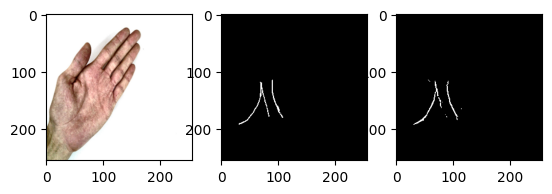

#Test 2 | f1: 0.6085577947322858, iou: 0.4373576310222203


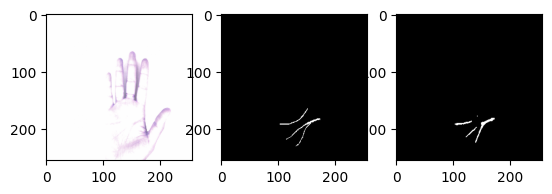

#Test 3 | f1: 0.5870967266075307, iou: 0.41552511419973165


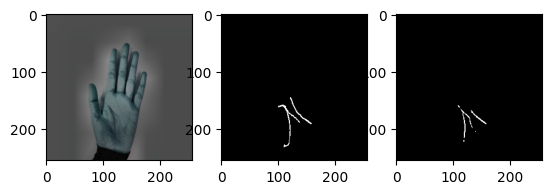

#Test 4 | f1: 0.7845083910964228, iou: 0.6454248366206196


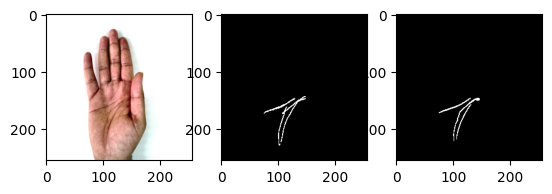

#Test 5 | f1: 0.7626112261641268, iou: 0.6163069544671217


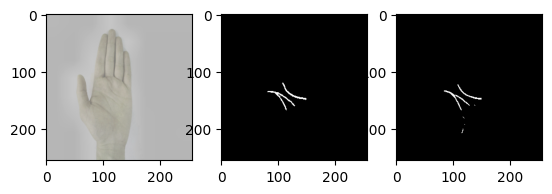

#Test 6 | f1: 0.5772495261726295, iou: 0.40572792367496197


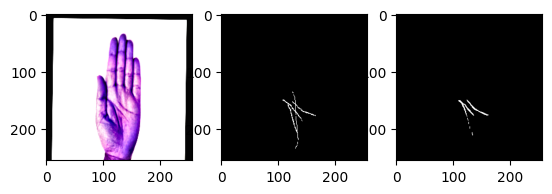

#Test 7 | f1: 0.794520498010887, iou: 0.6590909091124312


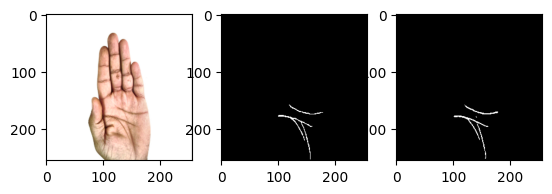

#Test 8 | f1: 0.5981307944572921, iou: 0.42666666670306874


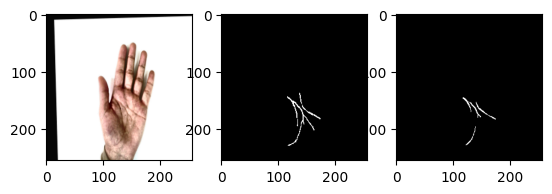

#Test 9 | f1: 0.7774010800259643, iou: 0.6358595194309391


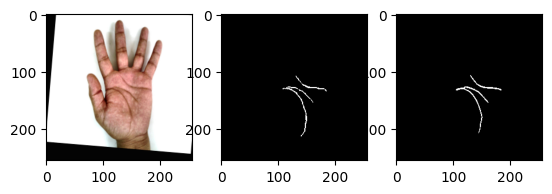

#Test 10 | f1: 0.7606490371698743, iou: 0.6137479541945582


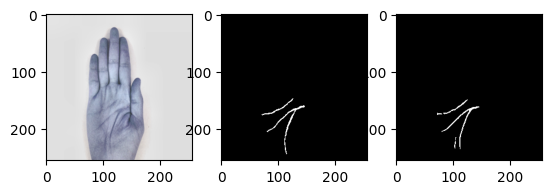

In [31]:
k = 1
f1_list = []
iou_list = []
for data in test_loader:
    if k > 10:
        break
    img = data['image']
    mask = data['mask']
    with torch.no_grad():
        img = img.to(device=DEVICE, dtype=torch.float32)
        mask = mask.to(device=DEVICE, dtype=torch.float32)

        output = net(img).squeeze(0)
        img = img.cpu().detach()
        output = np.apply_along_axis(lambda x: [1,1,1] if x > 0.05 else [0,0,0], 0, output.cpu().detach())
        mask = np.apply_along_axis(lambda x: [1,1,1] if x > 0.5 else [0,0,0], 0, mask.cpu().detach())

        f1 = F1Score(output, mask)
        iou = IOUScore(output, mask)
        f1_list.append(f1)
        iou_list.append(iou)

        print(f"#Test {k} | f1: {f1}, iou: {iou}")
        output = torch.Tensor(output)
        mask = torch.Tensor(mask)
        plt.subplot(1,3,1)
        plt.imshow(make_grid(img.squeeze().permute((1,2,0))))
        plt.subplot(1,3,2)
        plt.imshow(make_grid(mask.permute((1,2,0))))
        plt.subplot(1,3,3)
        plt.imshow(make_grid(output.permute((1,2,0))))
        plt.show() 

        # TODO: Edit save path
        plt.imshow(make_grid(mask.permute((1,2,0))))
        # plt.savefig('./outputs/masks/mask{}.png'.format(k))
        plt.savefig('./outputs/masks/my_mask{}.png'.format(k))

        plt.imshow(make_grid(output.permute((1,2,0))))
        # plt.savefig('./outputs/preds/pred{}.png'.format(k))
        plt.savefig('./outputs/preds/my_pred{}.png'.format(k))
        plt.close()
        
    k += 1

In [32]:
# original test set && checkpoint_epoch35.pth model
print(f"f1: {np.mean(f1_list)}, iou: {np.mean(iou_list)}")

f1: 0.6890818811027961, iou: 0.5326397164628486


In [33]:
# original test set && checkpoint_aug_epoch70.pth model
print(f"f1: {np.mean(f1_list)}, iou: {np.mean(iou_list)}")

f1: 0.6890818811027961, iou: 0.5326397164628486


#Experiments

In [ ]:
# pip install pyheif

In [34]:
import pyheif

In [ ]:
def heic_to_jpeg(heic_dir, jpeg_dir):

    heif_file = pyheif.read(heic_dir)

    image = Image.frombytes(
        heif_file.mode,
        heif_file.size,
        heif_file.data,
        "raw",
        heif_file.mode,
        heif_file.stride
        )

    print(heif_file)
    image.save(jpeg_dir,"JPEG")

In [ ]:
# heic_to_jpeg("./inputs/IMG_6732.HEIC", "./inputs/IMG_6732.jpg")

In [35]:
def detect(jpeg_dir, save=True):
    pil_img = Image.open(jpeg_dir)

    img = np.asarray(pil_img.resize((256, 256), resample=Image.NEAREST))
    img_name = jpeg_dir.split("/")[-1].split(".")[0]

    plt.subplot(1,2,1)
    plt.imshow(img)

    img = img / 255
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).permute(0,3,1,2).to(DEVICE)
    pred = net(img).squeeze(0)
    # pred = torch.Tensor(np.apply_along_axis(lambda x: [1,1,1] if x > 0.03 else [0,0,0], 0, pred.cpu().detach()))
    pred = torch.Tensor(np.apply_along_axis(lambda x: [1,1,1] if x > 0.04 else [0,0,0], 0, pred.cpu().detach()))
    
    plt.subplot(1,2,2)
    plt.imshow(make_grid(pred.permute((1,2,0))))
    plt.show()

    plt.imshow(make_grid(pred.permute((1,2,0))))
    plt.savefig('./outputs/preds/{}.png'.format(img_name))
    plt.close()

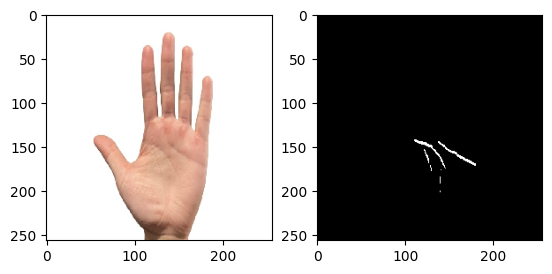

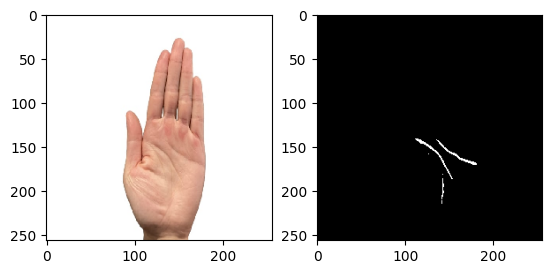

In [36]:
detect("./inputs/hand1_1.jpg")
detect("./inputs/hand1_2.jpg")

In [ ]:
def is_path_exists(file_path: str) -> bool:
    return os.path.exists(file_path)

def check_path_exists(file_path: str) -> None:
    error_text = f"MyDebug: {file_path} - file not found"
    assert is_path_exists(file_path), error_text

In [1]:
# TODO: Detect image
image_path = "../data/IMG_0364.jpg"
check_path_exists(image_path)
detect(image_path)

NameError: name 'check_path_exists' is not defined

In [ ]:
# detect("./inputs/hand2_1.jpeg")
# detect("./inputs/hand2_2.jpeg")
# detect("./inputs/hand2_3.jpg")
# detect("./inputs/hand2_4.jpg")

In [ ]:
# detect("./inputs/hand4_1.jpeg")
# detect("./inputs/hand4_2.jpeg")
# detect("./inputs/hand4_3.jpg")
# detect("./inputs/hand4_4.jpg")